# Plotting

## Config

In [ ]:

import os
import json
from glob import glob
from collections import defaultdict


import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
from statistics import mean
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET
import pandas as pd

In [ ]:
# ------------------------------- setting start ------------------------------ #
# color
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
errorbar_color = "#3A3A3A"

# font
csfont = {'family':'Times New Roman', 'serif': 'Times' , 'size' : 23}
plt.rc('text', usetex=True)
plt.rc('font', **csfont)


# bar plot size
bar_width = 0.4
bar_btw_space = 0.04
bar_space = 0.2

# errorbar plot size
err_lw=1.5
err_capsize=4
err_capthick=1.5

# set fig size
figsize=(6.4, 4.8)
# -------------------------------- setting end ------------------------------- #

In [ ]:
SCENE_NAME_LIST = ['drjohnson-dw50', 'bicycle-dw50', 'ficus', 'hotdog', 'lego', 'mic', 'ship']


def set_metric_ylim_fig(ax, metric_key, scene_name):
    """
    Set fixed y-axis limits for different metrics to ensure consistency across plots.
    
    Args:
        ax: matplotlib axes object
        metric_key: string, one of 'PSNR', 'SSIM', 'LPIPS'
    """
    
    # for outdoor scene (NeRF MIP360)
    if 'bicycle' in scene_name:
        if metric_key == 'PSNR':
            ax.set_ylim(20, 24)
        elif metric_key == 'SSIM':
            ax.set_ylim(0.35, 0.65)
        elif metric_key == 'LPIPS':
            pass
            # ax.set_ylim(0, 0.2)
    elif 'drjohnson' in scene_name:
        pass
    # for synthetic scenes (NeRF blender)
    else: 
        if metric_key == 'PSNR':
            ax.set_ylim(24.5, 35.0)
        elif metric_key == 'SSIM':
            ax.set_ylim(0.8, 1.0)
        elif metric_key == 'LPIPS':
            # ax.set_ylim(0, 0.2)
            pass
    
def set_metric_ylim_delta(ax, metric_key):
    """
    Set fixed y-axis limits for delta plots.
    
    Args:
        ax: matplotlib axes object
        metric_key: string, one of 'PSNR', 'SSIM', 'LPIPS'
    """
    if metric_key == 'PSNR':
        ax.set_ylim(-0.5, 5.5)  # Delta range for PSNR improvement
    elif metric_key == 'SSIM':
        ax.set_ylim(-0.01, 0.10)  # Delta range for SSIM improvement
    elif metric_key == 'LPIPS':
        # ax.set_ylim(-0.15, 0.01)  # Delta range for LPIPS improvement (lower is better)
        pass


## Figure Budget Policy

In [ ]:

def budget_policy_curves():
    """
    Plot metrics vs budget for different budgeting policies.
    """
    ITERATION = 'ours_15000'
    MESH_ITERATION = 'ours_1'
    
    input_dir = Path('./data') / SCENE_NAME
    output_dir = Path('./plots') / 'budget_policy_curves' / SCENE_NAME
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define policies with their configurations
    policies = [
        {'name': 'area', 'label': 'Area-based', 'marker': 'o', 'color': color_palette[1]},
        {'name': 'distortion', 'label': 'Distortion-based', 'marker': 's', 'color': color_palette[2]},
        {'name': 'uniform', 'label': 'Uniform', 'marker': '^', 'color': color_palette[3]},
        {'name': 'planarity2', 'label': 'Planarity', 'marker': '1', 'color': color_palette[4]},
        # {'name': 'mixed_v1g3', 'label': 'Mixed vis1:geo3', 'marker': '1', 'color': color_palette[4]},
        # {'name': 'mixed_v2g2', 'label': 'Mixed vis1:geo1', 'marker': '2', 'color': color_palette[5]},
        # {'name': 'mixed_v3g1', 'label': 'Mixed vis3:geo1', 'marker': '3', 'color': color_palette[6]},
    ]
    
    budgets = [40000, 80000, 160000, 320000, 640000]
    
    metrics = {
        'PSNR': {'ylabel': 'PSNR (dB)', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'},
    }
    
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting {metric_key}")
        print(f"{'='*60}")
        
        # 1. Get Pure mesh baseline
        mesh_mean = None
        mesh_stderr = None
        
        mesh_file = input_dir / 'area_1_occlusion' / 'per_view_gs_mesh.json'
        if mesh_file.exists():
            with open(mesh_file, 'r') as f:
                data = json.load(f)
            
            iter_key = MESH_ITERATION if MESH_ITERATION in data else ITERATION
            
            if iter_key in data:
                metric_data = data[iter_key][metric_key]
                if isinstance(metric_data, dict):
                    values = [v for v in metric_data.values() if v != -1.0]
                else:
                    values = [metric_data]
                
                mesh_mean = np.mean(values)
                std_val = np.std(values)
                mesh_stderr = std_val / np.sqrt(len(values))
                print(f"Pure Mesh - {metric_key}: mean={mesh_mean:.4f}, std={std_val:.4f}, n={len(values)}")
        
        # 2. Process each policy
        for policy in policies:
            policy_name = policy['name']
            xs = []
            ys = []
            errs = []
            
            # Add pure mesh point at budget=0
            if mesh_mean is not None:
                xs.append(0)
                ys.append(mesh_mean)
                errs.append(mesh_stderr)
            
            print(f"\nProcessing {policy['label']}:")
            for budget in budgets:
                policy_file = input_dir / f"{policy_name}_{budget}_occlusion" / 'per_view_gs_mesh.json'
                
                if policy_file.exists():
                    with open(policy_file, 'r') as f:
                        data = json.load(f)
                    
                    if ITERATION in data:
                        metric_data = data[ITERATION][metric_key]
                        if isinstance(metric_data, dict):
                            values = [v for v in metric_data.values() if v != -1.0]
                        else:
                            values = [metric_data]
                        
                        mean_val = np.mean(values)
                        std_val = np.std(values)
                        stderr = std_val / np.sqrt(len(values))
                        num_splats = data[ITERATION].get('num_splats', budget)
                        
                        xs.append(num_splats)
                        ys.append(mean_val)
                        errs.append(stderr)
                        
                        print(f"  Budget {budget}: mean={mean_val:.4f}, std={std_val:.4f}, splats={num_splats}")
            
            # Plot this policy
            if xs:
                print(f"  Plotting {len(xs)} points for {policy['label']}")
                ax.errorbar(xs, ys, yerr=errs,
                           marker=policy['marker'], markersize=8, linewidth=2.5,
                           capsize=err_capsize, capthick=err_capthick,
                           color=policy['color'], label=policy['label'], zorder=2)
            else:
                print(f"  No data to plot for {policy['label']}!")
        
        # Formatting
        ax.set_xlabel('Bit Budget (\#Gaussians K)', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        
        set_metric_ylim_fig(ax, metric_key, SCENE_NAME)
        
        # Format x-axis to show values in K (thousands)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x > 0 else '0'))
        
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        base_name = f'{metric_key}_vs_budget_{SCENE_NAME}'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()



# [TODO] [NOTE] fix y-axis range to enable comparison across plots
# the exact ranges for each set of figures might differ

# SCENE_NAME = 'drjohnson-dw50'
# budget_policy_curves()


for name in SCENE_NAME_LIST:
    SCENE_NAME = name
    budget_policy_curves()

## Figure Delta (DTGS - Pure Mesh)

In [ ]:

def policy_budget_delta_curves():
    """
    Plot average delta (improvement over pure mesh) across all scenes.
    
    Average across all nerf-synthetic scenes 
    (the 5 scenes we used are ficus, hotdog, lego, mic, ship)
    x-axis: budget number (0, 40k, 80k, 160k, 320k, 640k)
    y-axis: delta of quality in PSNR/SSIM/LPIPS (compared to pure mesh baseline)
    hue: different budgeting policies
    """
    ITERATION = 'ours_15000'
    MESH_ITERATION = 'ours_1'
    
    budgets = [40000, 80000, 160000, 320000, 640000]
    
    # Define policies with their configurations
    policies = [
        {'name': 'area', 'label': 'Area-based', 'marker': 'o', 'color': color_palette[1]},
        {'name': 'distortion', 'label': 'Distortion-based', 'marker': 's', 'color': color_palette[2]},
        {'name': 'uniform', 'label': 'Uniform', 'marker': '^', 'color': color_palette[3]},
        {'name': 'planarity2', 'label': 'Planarity', 'marker': '1', 'color': color_palette[4]},
        # {'name': 'mixed_v1g3', 'label': 'Mixed vis1:geo3', 'marker': '1', 'color': color_palette[4]},
        # {'name': 'mixed_v2g2', 'label': 'Mixed vis1:geo1', 'marker': '2', 'color': color_palette[5]},
        # {'name': 'mixed_v3g1', 'label': 'Mixed vis3:geo1', 'marker': '3', 'color': color_palette[6]},
    ]
    
    input_base = Path('./data')
    output_dir = Path('./plots') / 'budget_policy_delta_curves'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    metrics = {
        'PSNR': {'ylabel': r'$\Delta$ in PSNR (dB)', 'title': 'PSNR Improvement'},
        'SSIM': {'ylabel': r'$\Delta$ in SSIM', 'title': 'SSIM Improvement'},
        'LPIPS': {'ylabel': r'$\Delta$ LPIPS', 'title': 'LPIPS Improvement'}
    }
    
    # For each metric, create one plot
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Computing Average Delta for {metric_key}")
        print(f"{'='*60}")
        
        # Store data for each policy
        policy_data = {p['name']: {'xs': [], 'ys': [], 'errs': []} for p in policies}
        
        # For each budget level
        for budget in budgets:
            print(f"\nProcessing budget: {budget}")
            
            # Collect deltas for each policy across all scenes
            policy_deltas = {p['name']: [] for p in policies}
            
            for scene in SCENE_NAME_LIST:
                scene_dir = input_base / scene
                
                # Get pure mesh baseline for this scene
                mesh_file = scene_dir / 'area_1_occlusion' / 'per_view_gs_mesh.json'
                
                if not mesh_file.exists():
                    print(f"  [WARN] Missing mesh file for {scene}")
                    continue
                
                with open(mesh_file, 'r') as f:
                    mesh_data = json.load(f)
                
                iter_key = MESH_ITERATION if MESH_ITERATION in mesh_data else ITERATION
                
                if iter_key not in mesh_data:
                    print(f"  [WARN] No iteration key found in mesh file for {scene}")
                    continue
                
                # Get baseline metric value
                mesh_metric = mesh_data[iter_key][metric_key]
                if isinstance(mesh_metric, dict):
                    mesh_values = [v for v in mesh_metric.values() if v != -1.0]
                    baseline = np.mean(mesh_values)
                else:
                    baseline = mesh_metric
                
                # For each policy, compute delta
                for policy in policies:
                    policy_name = policy['name']
                    policy_file = scene_dir / f'{policy_name}_{budget}_occlusion' / 'per_view_gs_mesh.json'
                    
                    if not policy_file.exists():
                        print(f"  [WARN] Missing {policy_name} file for {scene} at budget {budget}")
                        continue
                    
                    with open(policy_file, 'r') as f:
                        policy_file_data = json.load(f)
                    
                    if ITERATION not in policy_file_data:
                        print(f"  [WARN] No {ITERATION} in {policy_name} file for {scene}")
                        continue
                    
                    # Get policy metric value
                    policy_metric = policy_file_data[ITERATION][metric_key]
                    if isinstance(policy_metric, dict):
                        policy_values = [v for v in policy_metric.values() if v != -1.0]
                        policy_val = np.mean(policy_values)
                    else:
                        policy_val = policy_metric
                    
                    # Compute delta (improvement over baseline)
                    # For LPIPS, lower is better
                    delta = policy_val - baseline  # Positive = improvement
                    
                    policy_deltas[policy_name].append(delta)
                    print(f"  {scene} {policy_name}: baseline={baseline:.4f}, policy={policy_val:.4f}, delta={delta:.4f}")
            
            # Compute average delta and standard error across scenes
            for policy in policies:
                policy_name = policy['name']
                if len(policy_deltas[policy_name]) > 0:
                    deltas = np.array(policy_deltas[policy_name])
                    mean_delta = np.mean(deltas)
                    std_delta = np.std(deltas)
                    stderr_delta = std_delta / np.sqrt(len(deltas))
                    
                    policy_data[policy_name]['xs'].append(budget)
                    policy_data[policy_name]['ys'].append(mean_delta)
                    policy_data[policy_name]['errs'].append(stderr_delta)
                    
                    print(f"  {policy_name} average: mean={mean_delta:.4f}, std={std_delta:.4f}, n={len(deltas)}")
        
        # Add budget=0 point (delta=0 by definition)
        for policy in policies:
            policy_name = policy['name']
            if len(policy_data[policy_name]['xs']) > 0:
                policy_data[policy_name]['xs'].insert(0, 0)
                policy_data[policy_name]['ys'].insert(0, 0.0)
                policy_data[policy_name]['errs'].insert(0, 0.0)
        
        # Plot each policy
        for policy in policies:
            policy_name = policy['name']
            if len(policy_data[policy_name]['xs']) > 0:
                ax.errorbar(
                    policy_data[policy_name]['xs'], 
                    policy_data[policy_name]['ys'], 
                    yerr=policy_data[policy_name]['errs'],
                    marker=policy['marker'], 
                    markersize=8, 
                    linewidth=2.5,
                    capsize=err_capsize, 
                    capthick=err_capthick,
                    color=policy['color'], 
                    label=policy['label'], 
                    zorder=2
                )
                print(f"\n[INFO] Plotted {len(policy_data[policy_name]['xs'])} points for {policy['label']}")
        
        # Add horizontal line at y=0 (no improvement)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
        
        # Formatting
        ax.set_xlabel('Bit Budget (\#Gaussians K)', fontsize=20)
        ax.set_ylabel(metric_info['ylabel'], fontsize=20)
        
        # Set fixed y-axis range
        set_metric_ylim_delta(ax, metric_key)
        
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x > 0 else '0'))
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        # Save both formats
        base_name = f'{metric_key}_delta_vs_budget_average'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n[INFO] Saved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()




policy_budget_delta_curves()


## Figure Iter

In [ ]:
def iter_budget_curves():
    """
    Plot metrics vs iteration for different budgets using distortion policy.
    
    x-axis: iteration number (1000, 2000, 3000, 4000, 5000, 6000, 7000, 10000, 12000, 15000)
    y-axis: quality in PSNR/SSIM/LPIPS
    hue: different bit budgets (0, 40k, 80k, 160k, 320k, 640k) using distortion policy
    """
    POLICY = 'distortion'  # Fixed policy
    MESH_ITERATION = 'ours_1'
    
    input_dir = Path('./data') / SCENE_NAME
    output_dir = Path('./plots') / 'iter_budget_curves' / SCENE_NAME
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define budgets with their configurations
    budget_configs = [
        {'budget': 0, 'label': 'Pure Mesh (0)', 'marker': 'o', 'color': color_palette[0], 'is_mesh': True},
        {'budget': 40000, 'label': '40K', 'marker': 's', 'color': color_palette[1], 'is_mesh': False},
        {'budget': 80000, 'label': '80K', 'marker': '^', 'color': color_palette[2], 'is_mesh': False},
        {'budget': 160000, 'label': '160K', 'marker': 'D', 'color': color_palette[3], 'is_mesh': False},
        {'budget': 320000, 'label': '320K', 'marker': 'v', 'color': color_palette[4], 'is_mesh': False},
        {'budget': 640000, 'label': '640K', 'marker': 'p', 'color': color_palette[5], 'is_mesh': False},
    ]
    
    # Define iterations to plot
    iterations = ['ours_1000', 'ours_2000', 'ours_3000', 'ours_4000', 'ours_5000', 
                  'ours_6000', 'ours_7000', 'ours_10000', 'ours_12000', 'ours_15000']
    iter_nums = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 10000, 12000, 15000]
    
    # Quality Metrics to plot
    metrics = {
        'PSNR': {'ylabel': 'PSNR (dB)', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        # 'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'}
    }
    
    # Plot each metric
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting {metric_key} vs Iteration for {POLICY} policy")
        print(f"{'='*60}")
        
        # Process each budget
        for config in budget_configs:
            budget = config['budget']
            xs = []
            ys = []
            errs = []
            
            if config['is_mesh']:
                # Pure mesh baseline - use area_1_occlusion
                mesh_file = input_dir / 'area_1_occlusion' / 'per_view_gs_mesh.json'
                print(f"\nProcessing {config['label']}:")
                print(f"  File: {mesh_file.name}, exists: {mesh_file.exists()}")
                
                if mesh_file.exists():
                    with open(mesh_file, 'r') as f:
                        data = json.load(f)
                    
                    # For pure mesh, only use MESH_ITERATION
                    if MESH_ITERATION in data:
                        metric_data = data[MESH_ITERATION][metric_key]
                        if isinstance(metric_data, dict):
                            values = [v for v in metric_data.values() if v != -1.0]
                        else:
                            values = [metric_data]
                        
                        mean_val = np.mean(values)
                        std_val = np.std(values)
                        stderr = std_val / np.sqrt(len(values))
                        
                        # Plot as a horizontal line (same value for all iterations)
                        xs = iter_nums
                        ys = [mean_val] * len(iter_nums)
                        errs = [stderr] * len(iter_nums)
                        
                        print(f"  Pure Mesh: mean={mean_val:.4f}, std={std_val:.4f}, n={len(values)}")
            else:
                # Policy with budget
                policy_file = input_dir / f'{POLICY}_{budget}_occlusion' / 'per_view_gs_mesh.json'
                print(f"\nProcessing {config['label']}:")
                print(f"  File: {policy_file.name}, exists: {policy_file.exists()}")
                
                if policy_file.exists():
                    with open(policy_file, 'r') as f:
                        data = json.load(f)
                    
                    for iter_key, iter_num in zip(iterations, iter_nums):
                        if iter_key in data:
                            metric_data = data[iter_key][metric_key]
                            if isinstance(metric_data, dict):
                                values = [v for v in metric_data.values() if v != -1.0]
                            else:
                                values = [metric_data]
                            
                            mean_val = np.mean(values)
                            std_val = np.std(values)
                            stderr = std_val / np.sqrt(len(values))
                            
                            xs.append(iter_num)
                            ys.append(mean_val)
                            errs.append(stderr)
                            
                            print(f"    Iter {iter_num}: mean={mean_val:.4f}, std={std_val:.4f}, n={len(values)}")
                        else:
                            print(f"    Iter {iter_num}: {iter_key} not found")
            
            # Plot this budget
            if xs:
                print(f"  Plotting {len(xs)} points for {config['label']}")
                ax.errorbar(xs, ys, yerr=errs,
                           marker=config['marker'], markersize=8, linewidth=2.5,
                           capsize=err_capsize, capthick=err_capthick,
                           color=config['color'], label=config['label'], zorder=2)
            else:
                print(f"  No data to plot for {config['label']}!")
        
        # Formatting
        ax.set_xlabel('Iteration', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        
        # Set fixed y-axis range
        set_metric_ylim_fig(ax, metric_key, SCENE_NAME)
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        # Save both formats
        base_name = f'{metric_key}_vs_iteration_{SCENE_NAME}_{POLICY}'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()



# SCENE_NAME = 'bicycle'
# iter_budget_curves()

for name in SCENE_NAME_LIST:
    SCENE_NAME = name
    iter_budget_curves()


  drjohnson-dw50 - PSNR: 27.5558
  drjohnson-dw50 - SSIM: 0.8487
  drjohnson-dw50 - LPIPS: 0.3605
  bicycle-dw50 - PSNR: 21.1066
  bicycle-dw50 - SSIM: 0.5360
  bicycle-dw50 - LPIPS: 0.4476
  ficus - PSNR: 25.1996
  ficus - SSIM: 0.9124
  ficus - LPIPS: 0.0881
  hotdog - PSNR: 28.9337
  hotdog - SSIM: 0.9528
  hotdog - LPIPS: 0.0716
  lego - PSNR: 25.3864
  lego - SSIM: 0.9057
  lego - LPIPS: 0.1008
  mic - PSNR: 25.0636
  mic - SSIM: 0.9045
  mic - LPIPS: 0.0903
  ship - PSNR: 24.9541
  ship - SSIM: 0.8163
  ship - LPIPS: 0.2113

Plotting Average Delta PSNR vs Iteration for distortion policy

Processing 40K:


NameError: name 'SCENES' is not defined

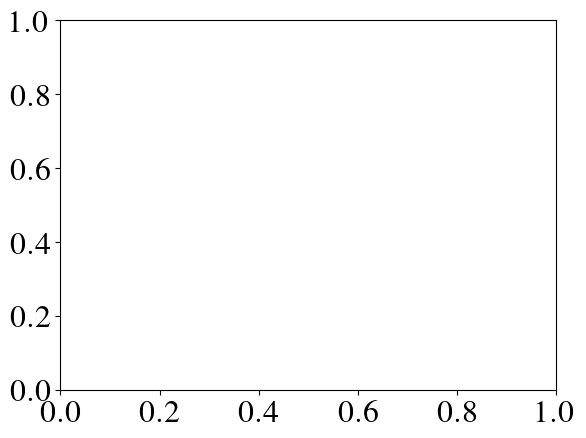

In [ ]:

def iter_budget_curves_delta_average():
    """
    Plot average delta (improvement over pure mesh) vs iteration for different budgets.
    Averaged across all scenes using distortion policy.
    
    x-axis: iteration number (1000, 2000, 3000, 4000, 5000, 6000, 7000, 10000, 12000, 15000)
    y-axis: delta of quality in PSNR/SSIM/LPIPS (compared to pure mesh baseline)
    hue: different bit budgets (40k, 80k, 160k, 320k, 640k) using distortion policy
    """
    POLICY = 'distortion'  # Fixed policy
    MESH_ITERATION = 'ours_1'
    
    
    input_dir = Path('./data')
    output_dir = Path('./plots') / 'iter_budget_curves_delta_average'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define budgets with their configurations (exclude pure mesh)
    budget_configs = [
        {'budget': 40000, 'label': '40K', 'marker': 's', 'color': color_palette[1]},
        {'budget': 80000, 'label': '80K', 'marker': '^', 'color': color_palette[2]},
        {'budget': 160000, 'label': '160K', 'marker': 'D', 'color': color_palette[3]},
        {'budget': 320000, 'label': '320K', 'marker': 'v', 'color': color_palette[4]},
        {'budget': 640000, 'label': '640K', 'marker': 'p', 'color': color_palette[5]},
    ]
    
    # Define iterations to plot
    iterations = ['ours_1000', 'ours_2000', 'ours_3000', 'ours_4000', 'ours_5000', 
                  'ours_6000', 'ours_7000', 'ours_10000', 'ours_12000', 'ours_15000']
    iter_nums = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 10000, 12000, 15000]
    
    # Quality Metrics to plot
    metrics = {
        'PSNR': {'ylabel': r'$\Delta$ in PSNR (dB)', 'title': 'PSNR Improvement'},
        'SSIM': {'ylabel': r'$\Delta$ in SSIM', 'title': 'SSIM Improvement'},
        'LPIPS': {'ylabel': r'$\Delta$ LPIPS', 'title': 'LPIPS Improvement'}
    }
    
    # First, collect pure mesh baselines for each scene
    print(f"\n{'='*60}")
    print(f"Collecting Pure Mesh Baselines")
    print(f"{'='*60}")
    
    scene_baselines = {}
    for scene in SCENE_NAME_LIST:
        scene_dir = input_dir / scene
        mesh_file = scene_dir / 'area_1_occlusion' / 'per_view_gs_mesh.json'
        
        if mesh_file.exists():
            with open(mesh_file, 'r') as f:
                data = json.load(f)
            
            if MESH_ITERATION in data:
                scene_baselines[scene] = {}
                for metric_key in metrics.keys():
                    metric_data = data[MESH_ITERATION][metric_key]
                    if isinstance(metric_data, dict):
                        values = [v for v in metric_data.values() if v != -1.0]
                        scene_baselines[scene][metric_key] = np.mean(values)
                    else:
                        scene_baselines[scene][metric_key] = metric_data
                    
                    print(f"  {scene} - {metric_key}: {scene_baselines[scene][metric_key]:.4f}")
    
    # Plot each metric
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting Average Delta {metric_key} vs Iteration for {POLICY} policy")
        print(f"{'='*60}")
        
        # Process each budget
        for config in budget_configs:
            budget = config['budget']
            xs = []
            ys = []
            errs = []
            
            print(f"\nProcessing {config['label']}:")
            
            # For each iteration
            for iter_key, iter_num in zip(iterations, iter_nums):
                iter_deltas_all_scenes = []
                
                for scene in SCENES:
                    if scene not in scene_baselines:
                        continue
                    
                    baseline = scene_baselines[scene][metric_key]
                    scene_dir = input_dir / scene
                    policy_file = scene_dir / f'{POLICY}_{budget}_occlusion' / 'per_view_gs_mesh.json'
                    
                    if policy_file.exists():
                        with open(policy_file, 'r') as f:
                            data = json.load(f)
                        
                        if iter_key in data:
                            metric_data = data[iter_key][metric_key]
                            if isinstance(metric_data, dict):
                                values = [v for v in metric_data.values() if v != -1.0]
                                scene_mean = np.mean(values)
                            else:
                                scene_mean = metric_data
                            
                            # Compute delta (improvement over baseline)
                            # For LPIPS, lower is better, so we flip the sign
                            if metric_key == 'LPIPS':
                                delta = baseline - scene_mean  # Positive = improvement
                            else:
                                delta = scene_mean - baseline  # Positive = improvement
                            
                            iter_deltas_all_scenes.append(delta)
                
                # Compute average delta across scenes for this iteration
                if iter_deltas_all_scenes:
                    mean_delta = np.mean(iter_deltas_all_scenes)
                    std_delta = np.std(iter_deltas_all_scenes)
                    stderr_delta = std_delta / np.sqrt(len(iter_deltas_all_scenes))
                    
                    xs.append(iter_num)
                    ys.append(mean_delta)
                    errs.append(stderr_delta)
                    
                    print(f"  Iter {iter_num}: mean_delta={mean_delta:.4f}, std={std_delta:.4f}, n={len(iter_deltas_all_scenes)}")
                else:
                    print(f"  Iter {iter_num}: No data found")
            
            # Plot this budget
            if xs:
                print(f"  Plotting {len(xs)} points for {config['label']}")
                ax.errorbar(xs, ys, yerr=errs,
                           marker=config['marker'], markersize=8, linewidth=2.5,
                           capsize=err_capsize, capthick=err_capthick,
                           color=config['color'], label=config['label'], zorder=2)
            else:
                print(f"  No data to plot for {config['label']}!")
        
        # Add horizontal line at y=0 (no improvement)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
        
        # Formatting
        ax.set_xlabel('Iteration', fontsize=20)
        ax.set_ylabel(metric_info['ylabel'], fontsize=20)
        
        # Set fixed y-axis range for delta plots
        set_metric_ylim_delta(ax, metric_key)
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        # Save both formats
        base_name = f'{metric_key}_delta_vs_iteration_average_{POLICY}'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()


# Run delta averaged plot
iter_budget_curves_delta_average()

## Fig Renderer Comparison

compare DTGS, TGS, GaMeS

In [ ]:
def plot_renderer_comp():
    """
    Compare different renderer/training pipelines (DTGS, TGS, GaMeS)
    under same budget/scene using uniform policy.
    
    the renderer used consistently in training and evaluation
    
    
    x-axis: bit budget in #Gaussians K (40k, 80k, 160k, 320k, 640k)
    y-axis: quality in PSNR/SSIM/LPIPS
    hue: [DTGS (ours), TGS (ours), GaMeS]
    """
    ITERATION = 'ours_15000'
    MESH_ITERATION = 'ours_1'
    POLICY = 'uniform'
    
    input_dir = Path('./data')
    games_dir = Path('./data/games_results')
    output_dir = Path('./plots') / 'renderer_comp' / SCENE_NAME
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define renderers/pipelines with their configurations
    renderers = [
        {'name': 'dtgs', 'label': 'DTGS (Ours)', 'marker': 'o', 'color': color_palette[0], 
         'is_games': False},
        {'name': 'tgs', 'label': 'TGS (Ours)', 'marker': 's', 'color': color_palette[1], 
         'is_games': False},  # [TODO] Need TGS data
        {'name': 'games', 'label': 'GaMeS', 'marker': '^', 'color': color_palette[2], 
         'is_games': True},
    ]
    
    budgets = [40000, 80000, 160000, 320000, 640000]
    
    metrics = {
        'PSNR': {'ylabel': 'PSNR (dB)', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'},
    }
    
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting {metric_key} - Renderer Comparison for {SCENE_NAME}")
        print(f"{'='*60}")
        
        # 1. Get Pure mesh baseline (shared across all renderers)
        mesh_mean = None
        mesh_stderr = None
        
        mesh_file = input_dir / SCENE_NAME / 'area_1_occlusion' / 'per_view_gs_mesh.json'
        if mesh_file.exists():
            with open(mesh_file, 'r') as f:
                data = json.load(f)
            
            iter_key = MESH_ITERATION if MESH_ITERATION in data else ITERATION
            
            if iter_key in data:
                metric_data = data[iter_key][metric_key]
                if isinstance(metric_data, dict):
                    values = [v for v in metric_data.values() if v != -1.0]
                else:
                    values = [metric_data]
                
                mesh_mean = np.mean(values)
                std_val = np.std(values)
                mesh_stderr = std_val / np.sqrt(len(values))
                print(f"Pure Mesh - {metric_key}: mean={mesh_mean:.4f}, std={std_val:.4f}, n={len(values)}")
        
        # 2. Process each renderer
        for renderer in renderers:
            renderer_name = renderer['name']
            is_games = renderer['is_games']
            
            xs = []
            ys = []
            errs = []
            
            # [NOTE] Our x=0 is mesh background, whereas GaMeS is blank
            if mesh_mean is not None:
                xs.append(0)
                if is_games: #GaMeS results do not include pure mesh point
                    ys.append( 1 if metric_key=='LPIPS' else 0 )
                    errs.append(0)
                else: #our DTGS/TGS results include pure mesh point
                    ys.append(mesh_mean)
                    errs.append(mesh_stderr)
            
            print(f"\nProcessing {renderer['label']}:")
            
            for budget in budgets:
                # Determine the correct file path
                if is_games:
                    # GaMeS results are in games_results folder
                    scene_dir = games_dir / SCENE_NAME
                else:
                    # DTGS/TGS results are in main data folder
                    scene_dir = input_dir / SCENE_NAME
                
                if renderer_name == 'dtgs' or renderer_name == 'games':
                    policy_file = scene_dir / f'{POLICY}_{budget}_occlusion' / 'per_view_gs_mesh.json'
                elif renderer_name == 'tgs':
                    policy_file = scene_dir / f'{POLICY}_{budget}_no_occlusion' / 'per_view_gs_mesh.json'
                
                if policy_file.exists():
                    with open(policy_file, 'r') as f:
                        data = json.load(f)
                    
                    if ITERATION in data:
                        metric_data = data[ITERATION][metric_key]
                        if isinstance(metric_data, dict):
                            values = [v for v in metric_data.values() if v != -1.0]
                        else:
                            values = [metric_data]
                        
                        mean_val = np.mean(values)
                        std_val = np.std(values)
                        stderr = std_val / np.sqrt(len(values))
                        num_splats = data[ITERATION].get('num_splats', budget)
                        
                        xs.append(num_splats)
                        ys.append(mean_val)
                        errs.append(stderr)
                        
                        print(f"  Budget {budget}: mean={mean_val:.4f}, std={std_val:.4f}, splats={num_splats}")
                else:
                    print(f"  Budget {budget}: File not found - {policy_file}")
            
            # Plot this renderer
            if xs:
                print(f"  Plotting {len(xs)} points for {renderer['label']}")
                ax.errorbar(xs, ys, yerr=errs,
                           marker=renderer['marker'], markersize=8, linewidth=2.5,
                           capsize=err_capsize, capthick=err_capthick,
                           color=renderer['color'], label=renderer['label'], zorder=2)
            else:
                print(f"  No data to plot for {renderer['label']}!")
        
        # Formatting
        ax.set_xlabel('Bit Budget (\#Gaussians K)', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        
        # set_metric_ylim_fig(ax, metric_key, SCENE_NAME)
        
        # Format x-axis to show values in K (thousands)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x > 0 else '0'))
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        base_name = f'{metric_key}_renderer_comp_{SCENE_NAME}'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()


# Run for all scenes
for name in SCENE_NAME_LIST:
    SCENE_NAME = name
    plot_renderer_comp()

In [ ]:
def plot_renderer_comp_average():
    """
    Compare different renderer/training pipelines (DTGS, TGS, GaMeS)
    the renderer used consistently in training and evaluation
    averaged across all scenes using uniform policy.
    
    x-axis: bit budget in #Gaussians K (40k, 80k, 160k, 320k, 640k)
    y-axis: average quality in PSNR/SSIM/LPIPS across all scenes
    hue: [DTGS (ours), TGS (ours), GaMeS]
    """
    ITERATION = 'ours_15000'
    MESH_ITERATION = 'ours_1'
    POLICY = 'uniform'
    
    
    input_dir = Path('./data')
    games_dir = Path('./data/games_results')
    output_dir = Path('./plots') / 'renderer_comp_average'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define renderers/pipelines with their configurations
    renderers = [
        {'name': 'dtgs', 'label': 'DTGS (Ours)', 'marker': 'o', 'color': color_palette[0], 
         'is_games': False},
        {'name': 'tgs', 'label': 'TGS (Ours)', 'marker': 's', 'color': color_palette[1], 
         'is_games': False},  
        {'name': 'games', 'label': 'GaMeS', 'marker': '^', 'color': color_palette[2], 
         'is_games': True},
    ]
    
    budgets = [40000, 80000, 160000, 320000, 640000]
    
    metrics = {
        'PSNR': {'ylabel': 'PSNR (dB)', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'},
    }
    
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting Average {metric_key} - Renderer Comparison")
        print(f"{'='*60}")
        
        # 1. Get Pure mesh baseline averaged across all scenes
        mesh_values_all_scenes = []
        
        for scene in SCENE_NAME_LIST:
            mesh_file = input_dir / scene / 'area_1_occlusion' / 'per_view_gs_mesh.json'
            if mesh_file.exists():
                with open(mesh_file, 'r') as f:
                    data = json.load(f)
                
                iter_key = MESH_ITERATION if MESH_ITERATION in data else ITERATION
                
                if iter_key in data:
                    metric_data = data[iter_key][metric_key]
                    if isinstance(metric_data, dict):
                        values = [v for v in metric_data.values() if v != -1.0]
                        scene_mean = np.mean(values)
                    else:
                        scene_mean = metric_data
                    
                    mesh_values_all_scenes.append(scene_mean)
                    print(f"  {scene} - Pure Mesh: {scene_mean:.4f}")
        
        mesh_mean = None
        mesh_stderr = None
        if mesh_values_all_scenes:
            mesh_mean = np.mean(mesh_values_all_scenes)
            mesh_std = np.std(mesh_values_all_scenes)
            mesh_stderr = mesh_std / np.sqrt(len(mesh_values_all_scenes))
            print(f"Pure Mesh Average - {metric_key}: mean={mesh_mean:.4f}, std={mesh_std:.4f}, n={len(mesh_values_all_scenes)}")
        
        # 2. Process each renderer
        for renderer in renderers:
            renderer_name = renderer['name']
            is_games = renderer['is_games']
            
            xs = []
            ys = []
            errs = []
            
           # [NOTE] Our x=0 is mesh background, whereas GaMeS is blank
            if mesh_mean is not None:
                xs.append(0)
                if is_games: #GaMeS results do not include pure mesh point
                    ys.append( 1 if metric_key=='LPIPS' else 0 )
                    errs.append(0)
                else: #our DTGS/TGS results include pure mesh point
                    ys.append(mesh_mean)
                    errs.append(mesh_stderr)
            
            print(f"\nProcessing {renderer['label']}:")
            
            for budget in budgets:
                # Collect values across all scenes for this budget
                budget_values_all_scenes = []
                
                for scene in SCENES:
                    # Determine the correct file path
                    if is_games:
                        scene_dir = games_dir / scene
                    else:
                        scene_dir = input_dir / scene
                    
                    if renderer_name == 'dtgs' or renderer_name == 'games':
                        policy_file = scene_dir / f'{POLICY}_{budget}_occlusion' / 'per_view_gs_mesh.json'
                    else:
                        policy_file = scene_dir / f'{POLICY}_{budget}_no_occlusion' / 'per_view_gs_mesh.json'
                    
                    if policy_file.exists():
                        with open(policy_file, 'r') as f:
                            data = json.load(f)
                        
                        if ITERATION in data:
                            metric_data = data[ITERATION][metric_key]
                            if isinstance(metric_data, dict):
                                values = [v for v in metric_data.values() if v != -1.0]
                                scene_mean = np.mean(values)
                            else:
                                scene_mean = metric_data
                            
                            budget_values_all_scenes.append(scene_mean)
                            print(f"  {scene} @ {budget}: {scene_mean:.4f}")
                    else:
                        print(f"  {scene} @ {budget}: File not found")
                
                # Compute average across scenes
                if budget_values_all_scenes:
                    mean_val = np.mean(budget_values_all_scenes)
                    std_val = np.std(budget_values_all_scenes)
                    stderr = std_val / np.sqrt(len(budget_values_all_scenes))
                    
                    xs.append(budget)
                    ys.append(mean_val)
                    errs.append(stderr)
                    
                    print(f"  Budget {budget} Average: mean={mean_val:.4f}, std={std_val:.4f}, n={len(budget_values_all_scenes)}")
            
            # Plot this renderer
            if xs:
                print(f"  Plotting {len(xs)} points for {renderer['label']}")
                ax.errorbar(xs, ys, yerr=errs,
                           marker=renderer['marker'], markersize=8, linewidth=2.5,
                           capsize=err_capsize, capthick=err_capthick,
                           color=renderer['color'], label=renderer['label'], zorder=2)
            else:
                print(f"  No data to plot for {renderer['label']}!")
        
        # Formatting
        ax.set_xlabel('Bit Budget (\#Gaussians K)', fontsize=20)
        ax.set_ylabel(f"Average {metric_info['ylabel']}", fontsize=20)
        
        # Format x-axis to show values in K (thousands)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x > 0 else '0'))
        
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        base_name = f'{metric_key}_renderer_comp_average'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()


# Run averaged comparison
plot_renderer_comp_average()

## Fig Mesh Downsampling

In [ ]:
def plot_base_mesh_quality_comp():
    """
    Compare quality metrics for different mesh downsampling rates.
    
    Policy: distortion
    Budget: 0, 40K, 80K, 160K, 320K, 640K
    Iteration: 15K
    Scenes: bicycle (full, dw50, dw30, dw10)
    """
    ITERATION = 'ours_15000'
    MESH_ITERATION = 'ours_1'
    POLICY = 'distortion'
    
    input_dir = Path('./data')
    output_dir = Path('./plots') / 'mesh_downsampling_comp'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define mesh variants with their configurations
    mesh_variants = [
        {'name': 'bicycle', 'label': 'Full Mesh', 'marker': 'o', 'color': color_palette[0]},
        {'name': 'bicycle-dw50', 'label': 'Downsample 50\%', 'marker': 's', 'color': color_palette[1]},
        {'name': 'bicycle-dw30', 'label': 'Downsample 30\%', 'marker': '^', 'color': color_palette[2]},
        {'name': 'bicycle-dw10', 'label': 'Downsample 10\%', 'marker': 'D', 'color': color_palette[3]},
    ]
    
    budgets = [40000, 80000, 160000, 320000, 640000]
    
    metrics = {
        'PSNR': {'ylabel': 'PSNR (dB)', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'},
    }
    
    # Collect data for each metric
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting {metric_key} - Mesh Downsampling Comparison")
        print(f"{'='*60}")
        
        # Process each mesh variant
        for variant in mesh_variants:
            scene_name = variant['name']
            scene_dir = input_dir / scene_name
            
            xs = []
            ys = []
            errs = []
            
            # Get pure mesh baseline (budget = 0)
            mesh_file = scene_dir / 'area_1_occlusion' / 'per_view_gs_mesh.json'
            
            if mesh_file.exists():
                with open(mesh_file, 'r') as f:
                    mesh_data = json.load(f)
                
                iter_key = MESH_ITERATION if MESH_ITERATION in mesh_data else ITERATION
                
                if iter_key in mesh_data:
                    metric_data = mesh_data[iter_key][metric_key]
                    if isinstance(metric_data, dict):
                        values = [v for v in metric_data.values() if v != -1.0]
                    else:
                        values = [metric_data]
                    
                    mesh_mean = np.mean(values)
                    std_val = np.std(values)
                    mesh_stderr = std_val / np.sqrt(len(values))
                    
                    # Add pure mesh point at budget=0
                    xs.append(0)
                    ys.append(mesh_mean)
                    errs.append(mesh_stderr)
                    
                    print(f"{scene_name} - Pure Mesh: {mesh_mean:.4f}")
            
            # Get policy+budget results for each budget
            print(f"\nProcessing {variant['label']}:")
            for budget in budgets:
                policy_file = scene_dir / f'{POLICY}_{budget}_occlusion' / 'per_view_gs_mesh.json'
                
                if policy_file.exists():
                    with open(policy_file, 'r') as f:
                        data = json.load(f)
                    
                    if ITERATION in data:
                        metric_data = data[ITERATION][metric_key]
                        if isinstance(metric_data, dict):
                            values = [v for v in metric_data.values() if v != -1.0]
                        else:
                            values = [metric_data]
                        
                        mean_val = np.mean(values)
                        std_val = np.std(values)
                        stderr = std_val / np.sqrt(len(values))
                        num_splats = data[ITERATION].get('num_splats', budget)
                        
                        xs.append(num_splats)
                        ys.append(mean_val)
                        errs.append(stderr)
                        
                        print(f"  Budget {budget}: mean={mean_val:.4f}, std={std_val:.4f}, splats={num_splats}")
                else:
                    print(f"  Budget {budget}: File not found - {policy_file}")
            
            # Plot this mesh variant
            if xs:
                print(f"  Plotting {len(xs)} points for {variant['label']}")
                ax.errorbar(xs, ys, yerr=errs,
                           marker=variant['marker'], markersize=8, linewidth=2.5,
                           capsize=err_capsize, capthick=err_capthick,
                           color=variant['color'], label=variant['label'], zorder=2)
            else:
                print(f"  No data to plot for {variant['label']}!")
        
        # Formatting
        ax.set_xlabel('Bit Budget (\#Gaussians K)', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        
        # Format x-axis to show values in K (thousands)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x > 0 else '0'))
        
        set_metric_ylim_mesh_downsample(ax, metric_key)
        
        # Add grid for readability
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        # Save both formats
        base_name = f'{metric_key}_mesh_downsampling_comp'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()


# Run the comparison
def set_metric_ylim_mesh_downsample(ax, metric_key):
    """
    Set fixed y-axis limits for delta plots.
    
    Args:
        ax: matplotlib axes object
        metric_key: string, one of 'PSNR', 'SSIM', 'LPIPS'
    """
    if metric_key == 'PSNR':
        ax.set_ylim(18,24)  # Delta range for PSNR improvement
    elif metric_key == 'SSIM':
        # ax.set_ylim()  # Delta range for SSIM improvement
        pass
    elif metric_key == 'LPIPS':
        # ax.set_ylim(-0.15, 0.01)  # Delta range for LPIPS improvement (lower is better)
        pass


# Run the comparison
plot_base_mesh_quality_comp()

# Streaming Results

## Parsers and Config

In [ ]:

def parse_metric_log(log_path, metric_type='psnr'):
    """
    Parse PSNR or SSIM log file.
    Returns: dict with frame_id -> metric_value
    
    Args:
        log_path: Path to log file
        metric_type: 'psnr' or 'ssim' to determine which field to extract
    """
    metrics = {}
    if not log_path.exists():
        return metrics
    
    with open(log_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) >= 2:
                # Extract frame_id from "n:X" format
                frame_str = parts[0]
                if frame_str.startswith('n:'):
                    frame_id = int(frame_str.split(':')[1])
                    
                    # Look for the appropriate metric field
                    if metric_type == 'psnr':
                        search_key = 'psnr_avg:'
                    elif metric_type == 'ssim':
                        search_key = 'All:'  # SSIM uses "All:" for the overall value
                    
                    for part in parts:
                        if part.startswith(search_key):
                            metric_value = float(part.split(':')[1])
                            metrics[frame_id] = metric_value
                            break
    return metrics

def parse_vmaf_xml(xml_path, metric_type='vmaf'):
    """Parse VMAF XML file and return dict with frame data"""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        frame_data = {}
        for frame in root.findall('.//frame'):
            frame_num = int(frame.get('frameNum'))
            vmaf_score = float(frame.get('vmaf'))
            frame_data[frame_num] = vmaf_score
        
        return frame_data
        
    except Exception as e:
        print(f"Error parsing XML: {e}")
        return {}



In [ ]:
# ============================= Streaming Config ============================= #
# Single source of truth for streaming experiments

STREAMING_CONFIG = {
    'scene': 'bicycle-dw50',
    'policy': 'distortion',
    'budget': 640000,
    'iteration': 'ours_15000',
    'streaming_settings': 'streaming_0',
    
    # Tile configurations
    'tile_configs': [
        {'n_tile': 1, 'label': 'Adaptive-1', 'marker': 'o', 'color': color_palette[0]},
        
        {'n_tile': 4, 'label': 'Adaptive-4', 'marker': 's', 'color': color_palette[1]},
        {'n_tile': 16, 'label': 'Adaptive-16', 'marker': '^', 'color': color_palette[2]},
        # {'n_tile': 2, 'label': 'Adaptive-16', 'marker': '^', 'color': color_palette[2]},
        # {'n_tile': 8, 'label': 'Adaptive-16', 'marker': '^', 'color': color_palette[2]},
        
    ],
    
    # User traces
    'user_traces': ['user1_bicycle', 'user2_bicycle', 'user3_bicycle'],
    
    # Network traces
    'network_traces': [
        'trace1_static_high',
        'trace2_static_low',
        'trace3_fluctuation_high',
        'trace4_fluctuation_low'
    ],
    
    # Metrics
    'metrics': {
        'PSNR': {'file': 'psnr.log', 'ylabel': 'PSNR (dB)', 'parser': parse_metric_log},
        'SSIM': {'file': 'ssim.log', 'ylabel': 'SSIM', 'parser': parse_metric_log},
        'VMAF': {'file': 'vmaf.csv', 'ylabel': 'VMAF', 'parser': parse_vmaf_xml},
        # don't mind the .csv, the content is in XML format
    },
    
    # Paths
    'input_base': Path('./data/streaming'),
    'output_base': Path('./plots/streaming')
}

# ============================================================================ #


def get_streaming_path(scene, policy, budget, iteration, n_tile, user_trace, network_trace, streaming_settings, iter_name):
    """
    Construct streaming data path following the naming convention.
    
    Returns: Path object
    """
    return (STREAMING_CONFIG['input_base'] / scene / 
            f'{policy}_{budget}_occlusion' /
            f'iteration_{iteration.split("_")[1]}' /
            f'ply-adaptive-{n_tile}' / 
            user_trace / 
            network_trace / 
            streaming_settings / 
            iter_name)



## Line Plots 




config same as before
**scene is bicycle-dw50**



path name rules:
```
"data/streaming/${SCENE_NAME}/${POLICY}_${BUDGET}_${OCCLUSION_FLAG}/iteration_${ITERATION}/
- ply-adaptive-${N_TILE_DIM}/
    - ${USER_TRACE_NAME}/
        - ${NETWORK_TRACE_NAME}/
            - ${STREAMING_SETTINGS_NAME}"
```




In [ ]:


def plot_streaming_quality_overall_average():
    """
    Plot overall average quality across ALL user traces and network traces.
    Shows mean and standard deviation bands.
    
    Averages over: 3 users × 4 network traces = 12 combinations
    """
    
    cfg = STREAMING_CONFIG
    output_dir = cfg['output_base'] / 'line_plots' / 'overall_average' / cfg['scene']
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # For each metric
    for metric_key, metric_info in cfg['metrics'].items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting Overall Average {metric_key}")
        print(f"{'='*60}")
        
        # Plot each tile configuration averaged across ALL combinations
        for tile_cfg in cfg['tile_configs']:
            n_tile = tile_cfg['n_tile']
            
            # Collect data from all user-network combinations
            all_combinations_data = []
            
            for user_trace in cfg['user_traces']:
                for network_trace in cfg['network_traces']:
                    data_path = get_streaming_path(
                        cfg['scene'], cfg['policy'], cfg['budget'], 
                        cfg['iteration'], n_tile, user_trace, 
                        network_trace, cfg['streaming_settings'], 
                        cfg['iteration']
                    )
                    
                    metric_file = data_path / metric_info['file']
                    
                    if metric_file.exists():
                        data = metric_info['parser'](metric_file, metric_type=metric_key.lower())
                        if data:
                            all_combinations_data.append(data)
                            print(f"  Loaded: {user_trace}/{network_trace} - {len(data)} frames")
            
            if all_combinations_data:
                # Find common frames across all combinations
                all_frames = set(all_combinations_data[0].keys())
                for data in all_combinations_data[1:]:
                    all_frames &= set(data.keys())
                all_frames = sorted(all_frames)
                
                means = []
                stds = []
                
                for frame in all_frames:
                    frame_values = [data[frame] for data in all_combinations_data if frame in data]
                    if frame_values:
                        means.append(np.mean(frame_values))
                        stds.append(np.std(frame_values))
                
                means = np.array(means)
                stds = np.array(stds)
                
                # Plot mean line
                ax.plot(all_frames, means,
                       marker=tile_cfg['marker'], markevery=50, markersize=6,
                       linewidth=2, color=tile_cfg['color'],
                       label=tile_cfg['label'], zorder=2)
                
                # Plot std band
                ax.fill_between(all_frames, means - stds, means + stds,
                               alpha=0.2, color=tile_cfg['color'], zorder=1)
                
                print(f"\n  {tile_cfg['label']} overall average:")
                print(f"    Combinations: {len(all_combinations_data)}")
                print(f"    Frames: {len(all_frames)}")
                print(f"    Mean: {np.mean(means):.2f}")
                print(f"    Std: {np.mean(stds):.2f}")
            else:
                print(f"  No data found for {tile_cfg['label']}")
        
        # Formatting
        ax.set_xlabel('Frame Number', fontsize=20)
        ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        fig.set_constrained_layout(True)
        
        # Save
        base_name = f'{metric_key}_overall_average_budget{cfg["budget"]//1000}K'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n  Saved: {base_name}.png and .eps")
        
        plt.show()
        plt.close()


print("\n" + "="*60)
print("Generating Overall Average Plot (1 plot per metric)")
print("="*60)
plot_streaming_quality_overall_average()

In [ ]:


def plot_streaming_quality_individual():
    """
    Plot quality for each individual user-network trace combination.
    Creates 12 separate plots (3 users × 4 network traces).
    
    For each plot:
    - x-axis: frame number
    - y-axis: quality (PSNR/SSIM/VMAF)
    - hue: different n_tile configurations (1, 4, 16)
    """
    
    cfg = STREAMING_CONFIG
    output_dir = cfg['output_base'] / 'line_plots' / 'individual' / cfg['scene']
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # For each metric
    for metric_key, metric_info in cfg['metrics'].items():
        print(f"\n{'='*60}")
        print(f"Plotting Individual {metric_key}")
        print(f"{'='*60}")
        
        # For each user-network combination
        for user_trace in cfg['user_traces']:
            for network_trace in cfg['network_traces']:
                fig, ax = plt.subplots(figsize=figsize)
                
                print(f"\n{user_trace} - {network_trace}")
                
                # Plot each tile configuration
                for tile_cfg in cfg['tile_configs']:
                    n_tile = tile_cfg['n_tile']
                    
                    data_path = get_streaming_path(
                        cfg['scene'], cfg['policy'], cfg['budget'], 
                        cfg['iteration'], n_tile, user_trace, 
                        network_trace, cfg['streaming_settings'], 
                        cfg['iteration']
                    )
                    
                    metric_file = data_path / metric_info['file']
                    
                    if metric_file.exists():
                        data = metric_info['parser'](metric_file, metric_type=metric_key.lower())
                        
                        if data:
                            frames = sorted(data.keys())
                            values = [data[f] for f in frames]
                            
                            ax.plot(frames, values,
                                   marker=tile_cfg['marker'], markevery=50, markersize=6,
                                   linewidth=2, color=tile_cfg['color'],
                                   label=tile_cfg['label'], zorder=2)
                            
                            print(f"  {tile_cfg['label']}: {len(frames)} frames, "
                                  f"avg={np.mean(values):.2f}")
                        else:
                            print(f"  {tile_cfg['label']}: No data parsed")
                    else:
                        print(f"  {tile_cfg['label']}: File not found")
                
                # Formatting
                ax.set_xlabel('Frame Number', fontsize=20)
                ax.set_ylabel(f"Quality in {metric_info['ylabel']}", fontsize=20)
                ax.set_title(f"{user_trace} - {network_trace}", fontsize=18)
                ax.legend(loc='best', framealpha=0.9, fontsize=16)
                ax.tick_params(labelsize=18)
                ax.grid(axis='y', alpha=0.3, linestyle='--')
                ax.set_axisbelow(True)
                
                fig.set_constrained_layout(True)
                
                # Save
                base_name = f'{metric_key}_{user_trace}_{network_trace}'
                plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
                plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
                print(f"  Saved: {base_name}")
                
                plt.close()



# Run both plotting functions
print("\n" + "="*60)
print("Generating Individual Plots (12 plots per metric)")
print("="*60)
plot_streaming_quality_individual()


## Bar Plot

In [ ]:
def plot_streaming_bar():
    """
    Bar plot showing average quality for each network trace + overall average.
    
    For each metric (PSNR/SSIM/VMAF):
    - x-axis: 5 bar groups (4 network traces + 1 overall average)
    - Each group has bars for different n_tile configs (1, 4, 16)
    - Bars show average across 3 users with error bars
    """
    
    cfg = STREAMING_CONFIG
    output_dir = cfg['output_base'] / 'bar_plots' / cfg['scene']
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # For each metric
    for metric_key, metric_info in cfg['metrics'].items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting Bar Chart for {metric_key}")
        print(f"{'='*60}")
        
        # Prepare data structure
        x_labels = [trace.replace('trace', 'T').replace('_', ' ').title() 
                   for trace in cfg['network_traces']] + ['Overall']
        n_groups = len(x_labels)
        n_tiles = len(cfg['tile_configs'])
        
        # Bar positions using global config
        x_pos = np.arange(n_groups) * (n_tiles * bar_width + bar_space)
        
        # Collect data for each tile config
        for tile_idx, tile_cfg in enumerate(cfg['tile_configs']):
            n_tile = tile_cfg['n_tile']
            
            group_means = []
            group_stds = []
            
            # Process each network trace
            for network_trace in cfg['network_traces']:
                trace_values = []
                
                for user_trace in cfg['user_traces']:
                    data_path = get_streaming_path(
                        cfg['scene'], cfg['policy'], cfg['budget'],
                        cfg['iteration'], n_tile, user_trace,
                        network_trace, cfg['streaming_settings'],
                        cfg['iteration']
                    )
                    
                    metric_file = data_path / metric_info['file']
                    
                    if metric_file.exists():
                        data = metric_info['parser'](metric_file, metric_type=metric_key.lower())
                        if data:
                            user_avg = np.mean(list(data.values()))
                            trace_values.append(user_avg)
                
                if trace_values:
                    group_means.append(np.mean(trace_values))
                    group_stds.append(np.std(trace_values) / np.sqrt(len(trace_values)))
                    print(f"  {network_trace} - {tile_cfg['label']}: mean={np.mean(trace_values):.2f}")
                else:
                    group_means.append(0)
                    group_stds.append(0)
            
            # Overall average
            overall_values = []
            for user_trace in cfg['user_traces']:
                for network_trace in cfg['network_traces']:
                    data_path = get_streaming_path(
                        cfg['scene'], cfg['policy'], cfg['budget'],
                        cfg['iteration'], n_tile, user_trace,
                        network_trace, cfg['streaming_settings'],
                        cfg['iteration']
                    )
                    
                    metric_file = data_path / metric_info['file']
                    
                    if metric_file.exists():
                        data = metric_info['parser'](metric_file, metric_type=metric_key.lower())
                        if data:
                            overall_values.append(np.mean(list(data.values())))
            
            if overall_values:
                group_means.append(np.mean(overall_values))
                group_stds.append(np.std(overall_values) / np.sqrt(len(overall_values)))
            else:
                group_means.append(0)
                group_stds.append(0)
            
            # Plot bars using global bar_width and bar_btw_space
            offset = tile_idx * (bar_width + bar_btw_space)
            ax.bar(x_pos + offset, group_means, bar_width,
                   yerr=group_stds, capsize=err_capsize,
                   label=tile_cfg['label'], color=tile_cfg['color'],
                   error_kw={'elinewidth': err_lw, 'capthick': err_capthick})
        
        # Formatting
        ax.set_xlabel('Network Trace', fontsize=20)
        ax.set_ylabel(f"Average {metric_info['ylabel']}", fontsize=20)
        ax.set_xticks(x_pos + (n_tiles - 1) * (bar_width + bar_btw_space) / 2)
        ax.set_xticklabels(x_labels, rotation=15, ha='right')
        ax.legend(loc='best', framealpha=0.9, fontsize=16)
        ax.tick_params(labelsize=16)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        fig.set_constrained_layout(True)
        
        base_name = f'{metric_key}_bar_network_traces_budget{cfg["budget"]//1000}K'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n  Saved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()
print("\n" + "="*60)
print("Generating Bar Plots (1 plot per metric)")
print("="*60)
plot_streaming_bar()